In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
df = pd.read_csv('/Users/adamwidibagaskarta/mediacenter/mediacenter_2019-03-26T08-30-01.csv')

In [4]:
df.shape

(31824, 2)

In [5]:
df.head(10)

,page,product_name
0,http://mediacenter.surabaya.go.id/,\n
1,http://mediacenter.surabaya.go.id/,\n
2,http://mediacenter.surabaya.go.id/,\n Saya ada beli rumah di D...
3,http://mediacenter.surabaya.go.id/,\n
4,http://mediacenter.surabaya.go.id/,\n
5,http://mediacenter.surabaya.go.id/,\n
6,http://mediacenter.surabaya.go.id/,"\n Nama saya Hatma, alamat ..."
7,http://mediacenter.surabaya.go.id/,\n
8,http://mediacenter.surabaya.go.id/,\n
9,http://mediacenter.surabaya.go.id/,\n


In [ ]:
df = df[df['product_name'].str.len() > 21]

In [ ]:
df.shape

In [ ]:
df.iloc[1]['product_name']

In [ ]:
df['product_name'] = df['product_name'].replace('\n                    ','',regex=True)
df['product_name'] = df['product_name'].replace('\r','',regex=True)
df['product_name'] = df['product_name'].replace('\n','',regex=True)

In [ ]:
df.iloc[1]['product_name']

In [ ]:
factory = StemmerFactory()
stem = factory.create_stemmer()

In [ ]:
stemmer_data = []

In [ ]:
stemmer_data.clear()
for i in tqdm(range(df['page'].count()), desc='time'):
    stemmer_data.append(stem.stem(df.iloc[i]['product_name']))

In [ ]:
len(stemmer_data)

In [ ]:
df_stemmer = pd.DataFrame(data=stemmer_data, dtype=str)

In [ ]:
df_stemmer.rename(index={0:'0'}, inplace=True)

In [ ]:
df_stemmer.head(2)

In [ ]:
df_stemmer.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df_stemmer.to_csv('hasil_stemmer.csv')

In [6]:
df_stemmer = pd.read_csv('hasil_stemmer.csv')

In [7]:
df_stemmer = df_stemmer.dropna()

In [8]:
stop = StopWordRemoverFactory()
stopwords = stop.create_stop_word_remover()

In [9]:
clean_data = []

In [10]:
for i in tqdm(range(len(df_stemmer)), desc='time'):
    clean_data.append(stopwords.remove(df_stemmer.iloc[i]['keluhan']))

time: 100%|██████████| 7948/7948 [00:01<00:00, 4261.85it/s]


In [12]:
clean_data

['ada beli rumah diamond park sidoarjo bulan januari masuk listrik pln padahal unit udah jadi alas dari developer pln nya saat pasang kabel alas kabel tmnya ada benar pln punya stok kabel tm meski kurun waktu 3 bulan mesan kabel tm ada bijak butuh tempat tinggal sekarang tempat tinggal ada listrik belum juga pasang pln apakah begini cara kerja nya rakyat biasa yg butuh listrik tempat tinggal dan sudah tunggu terlalu lama',
 'nama hatma alamat rumah manyar sabrangan viii-b 36 mulyorejo surabaya tadi malam tetangga belah kiri rumah anak nya tinggal demam darah mohon segera fogging tindak lanjut khawatir tular sini kampung mohon padat duduk jadi mohon di prioritas terima kasih banyak',
 'mau tanya kait terima hibah adalah satu urus musholla al-islah jl kapas lor 1g no 2a 3tahun lalu aju mohon dana hibah bangun lantai 2 musholla baru informasi lanjut tahun 2018 pada tahap penandatanganan nphd sekarang di suruh tunggu padahal sudah 3 tahun benar cair php mohon jelas besar harap dengan nanti

In [13]:
clean = pd.DataFrame(clean_data, columns=['keluhan_clean'])

In [ ]:
clean.to_csv('keluhan_preprocessing.csv')

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vec = TfidfVectorizer(min_df=5, ngram_range=(1,2))

In [16]:
vz = vec.fit_transform(clean['keluhan_clean'])

In [17]:
tfidf = dict(zip(vec.get_feature_names(), vec.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

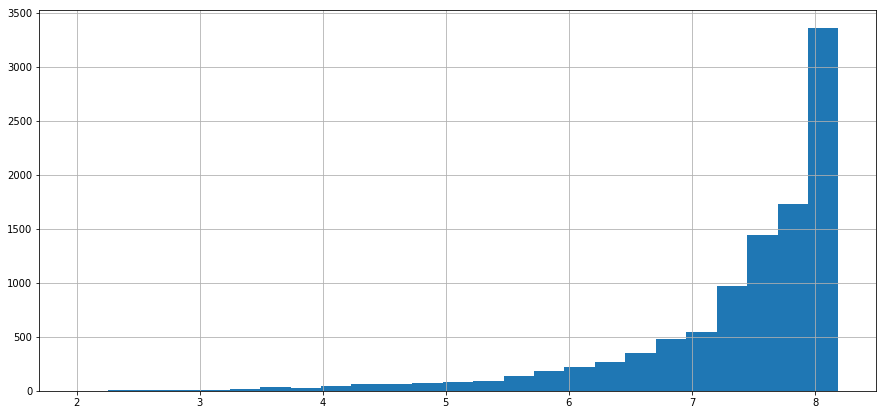

In [18]:
tfidf.tfidf.hist(bins=25, figsize=(15,7))

In [19]:
from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

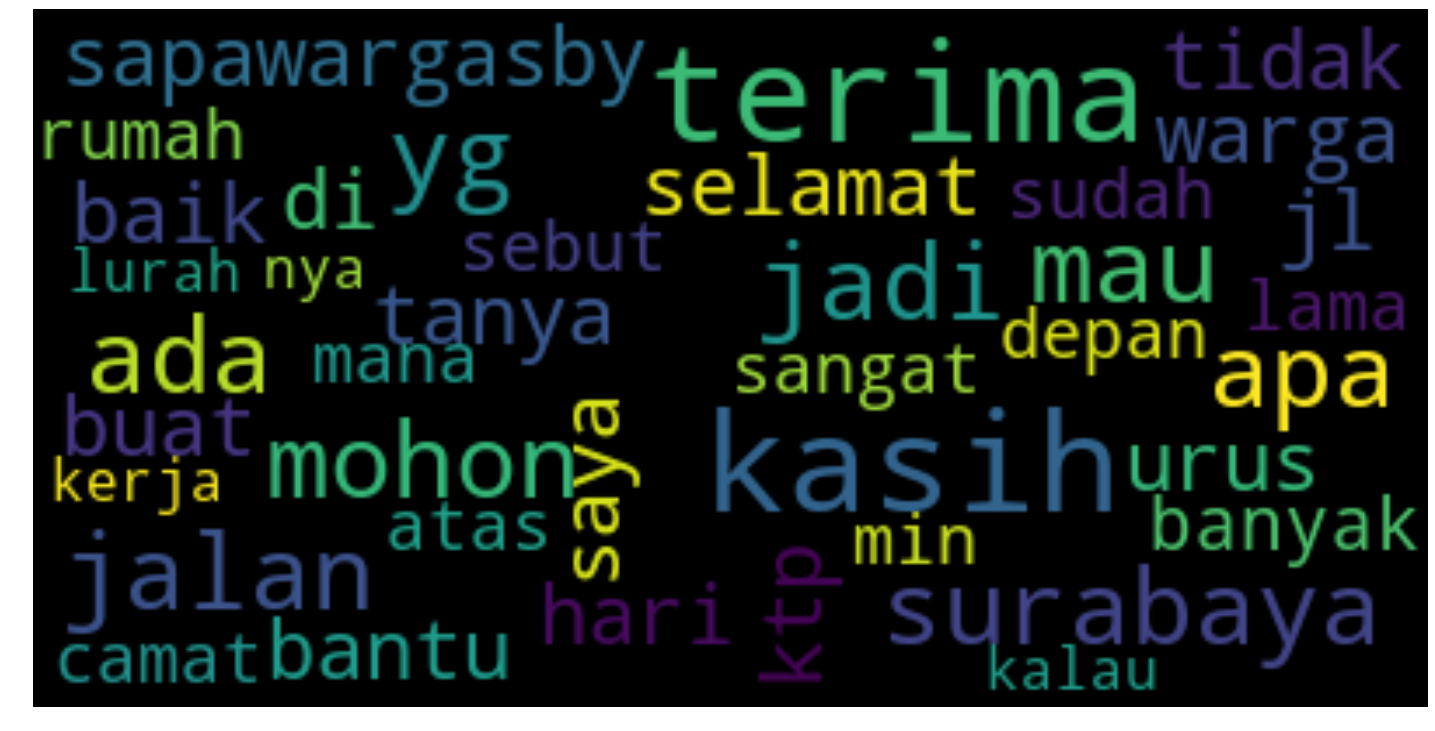

In [20]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

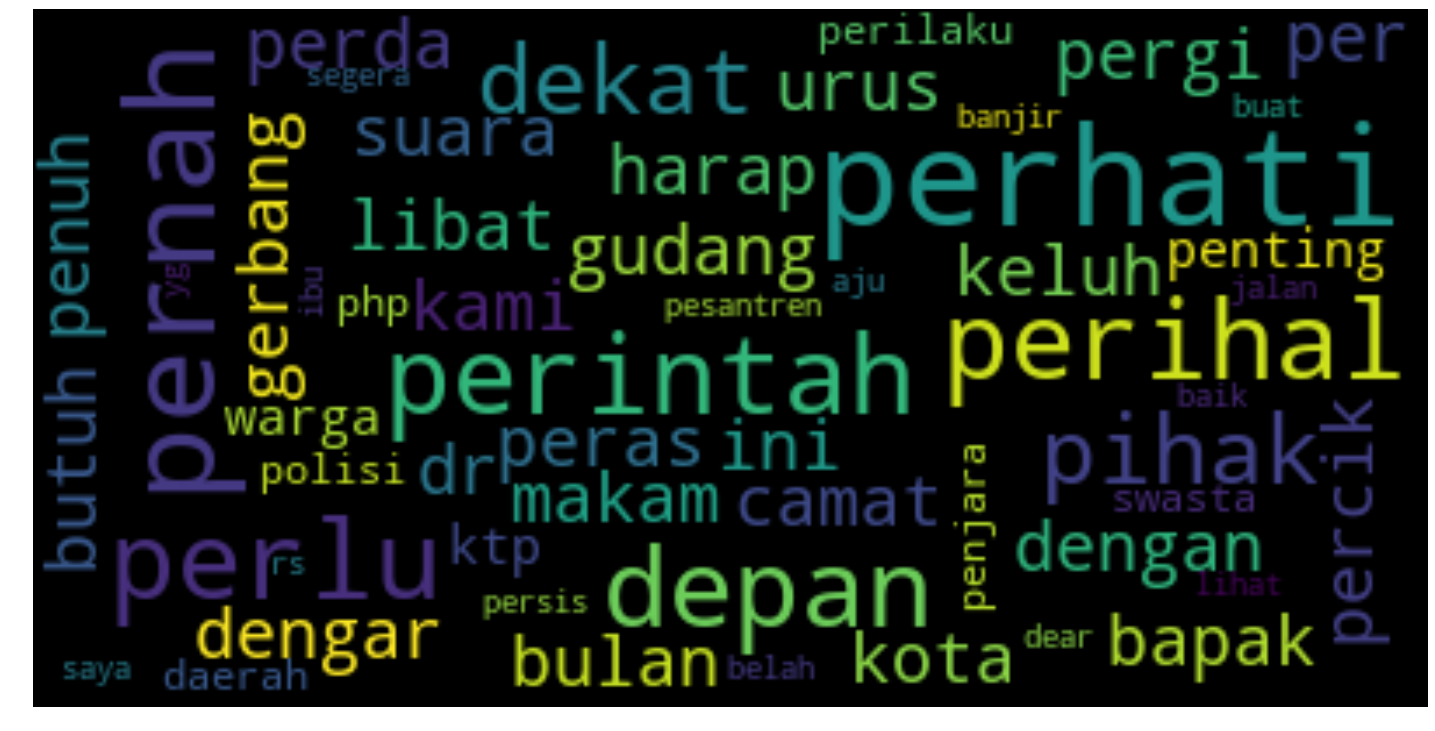

In [21]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

In [22]:
vz.shape

(7948, 10186)

In [23]:
distorsions = []
sil_scores = []
k_max = 30
for k in tqdm(range(2, k_max)):
    kmeans_model = KMeans(n_clusters=k, n_init=1, random_state=42, max_iter=1000)
    kmeans_model.fit(vz)
    sil_score = silhouette_score(vz, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

100%|██████████| 28/28 [04:12<00:00,  9.03s/it]


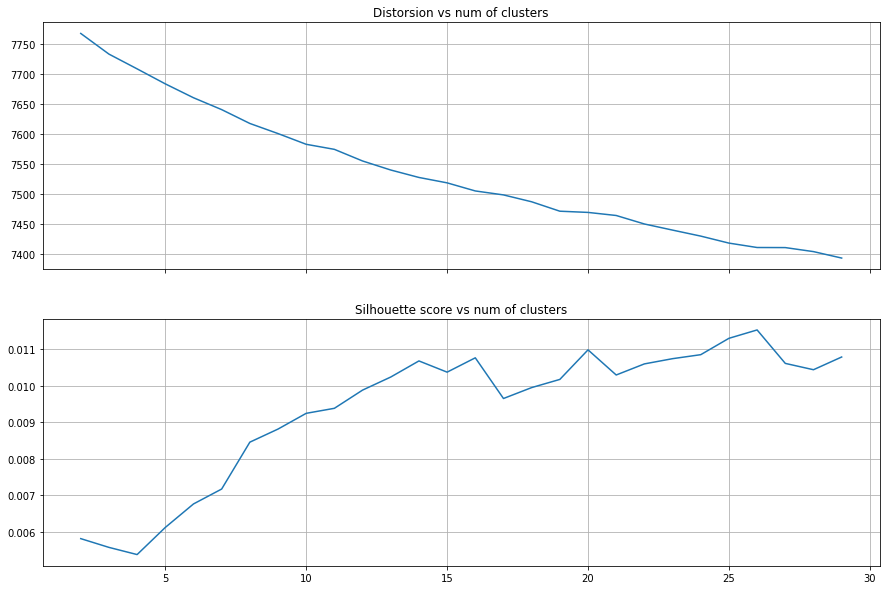

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

In [25]:
model = KMeans(n_clusters=26, max_iter=1000,n_init=1, random_state=42)

In [26]:
kmeans = model.fit(vz)

In [27]:
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [28]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
all_keywords = []
for i in range(26):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(26)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,ga,min,sapawargasby,kok ga,kok,buka,sapawargasby min,yg,kalo,dong
topic_1,sampah,banjir,air,salur,sungai,hujan,rumah,got,buang,bersih
topic_2,ktp,camat,jadi,bulan,rekam,urus,cetak,saya,lama,tahun
topic_3,surat,lurah,surat terang,urus,terang,urus surat,rt,rw,pindah,kk
topic_4,mohon,terima,kasih,terima kasih,yg,saya,surabaya,ada,bantu,ibu
topic_5,lubang,jalan,jalan lubang,kendara,bahaya,banyak,mohon,baik,depan,lubang jalan
topic_6,bu,bu risma,risma,yg,mohon,surabaya,warga,bantu,saya,mau
topic_7,daftar,cara,bagaimana,bagaimana cara,blc,cara daftar,daftar blc,cara bagaimana,rumah bahasa,bahasa
topic_8,info,mohon info,mohon,sapawargasby,sapawargasby mohon,apa,urus,e100ss,surabaya,kasih
topic_9,bus,suroboyo,suroboyo bus,plastik,botol,naik,bus suroboyo,botol plastik,naik bus,sapawargasby


In [ ]:
## sumarize 
# topic 1 : Banjir
# topic 2 : KTP
# topic 3 : Administrasi RT/RW
# topic 5 : Lubang jalan
# topic 9 : Bus Surabaya
# topic 10 : Akta kelahiran
# topic 11 : PJU Padam
# topic 12 : Jalan Macet
# topic 13 : Waktu Pelayanan
# topic 16 : Jalan rusak
# topic 19 : Lampu Jalan
# topic 22 : PDAM
# topic 25 : Karcis Parkir